<a href="https://colab.research.google.com/github/L1KASA/DL_Course/blob/main/lab1/6409_%D0%A2%D0%B0%D1%85%D0%BC%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%90%D0%A8_%D0%9B%D0%A01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 1

6409 Чернышова Дана

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
from keras.datasets import cifar10


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Форма обучающей выборки:', X_train.shape)
print('Форма меток обучающей выборки:', y_train.shape)
print('Форма тестовой выборки:', X_test.shape)
print('Форма меток тестовой выборки:', y_test.shape)


170498071/170498071 [==============================] - 7s 0us/step
Форма обучающей выборки: (50000, 32, 32, 3)
Форма меток обучающей выборки: (50000, 1)
Форма тестовой выборки: (10000, 32, 32, 3)
Форма меток тестовой выборки: (10000, 1)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



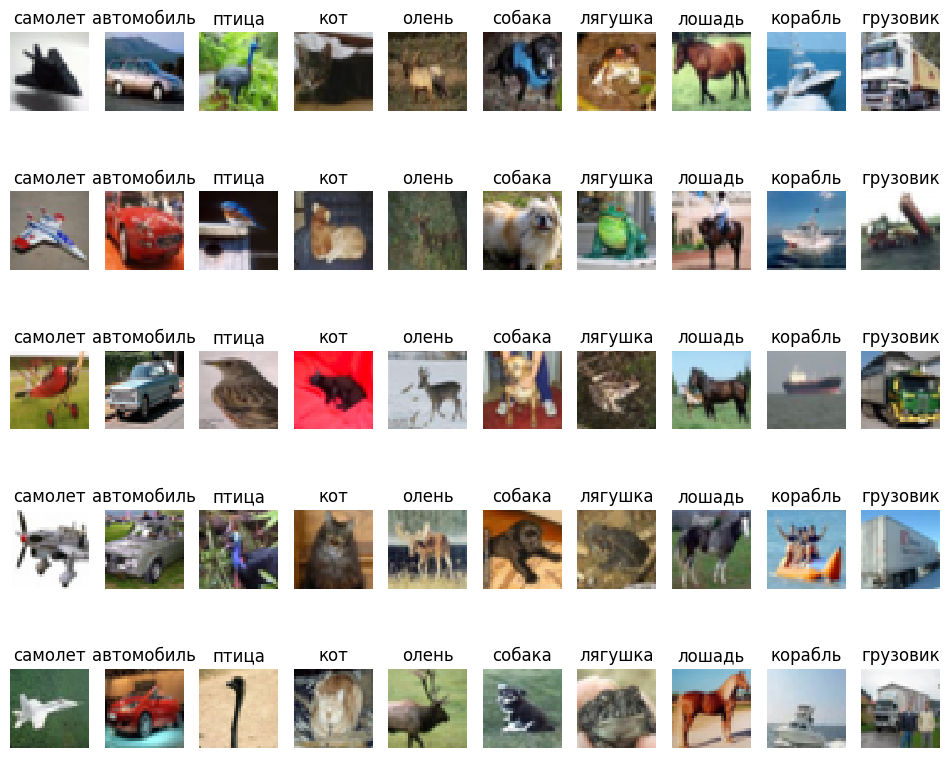

In [3]:
class_names = ['самолет', 'автомобиль', 'птица', 'кот', 'олень',
               'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

# Словарь для хранения индексов изображений для каждого класса
class_indices = {i: [] for i in range(10)}

# Заполнение словаря индексами изображений для каждого класса
for i in range(len(y_train)):
    class_indices[y_train[i][0]].append(i)

plt.figure(figsize=(12, 10))  # Создание новой фигуры для вывода изображений
num_examples_per_class = 5 # Количество примеров из каждого класса

for cls in range(10):
    indices = class_indices[cls]  # Получение индексов изображений для текущего класса
    for i, idx in enumerate(indices[:num_examples_per_class]):
        plt.subplot(num_examples_per_class, 10, i * 10 + cls + 1)  # Добавление подграфика в текущую фигуру
        plt.imshow(X_train[idx])  # Отображение изображения в подграфике
        plt.title(class_names[cls])  # Установка заголовка подграфика как числовой индекс класса
        plt.axis('off')  # Убираем оси координат

plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

In [4]:
# Преобразование изображений в одномерные массивы
x_train_flat = X_train.reshape(X_train.shape[0], -1)
x_test_flat = X_test.reshape(X_test.shape[0], -1)


x_train_flat, y_train = x_train_flat[:1000], y_train[:1000]
x_test_flat, y_test = x_test_flat[:100], y_test[:100]

x_train_flat = x_train_flat.reshape(x_train_flat.shape[0], -1)
x_test_flat = x_test_flat.reshape(x_test_flat.shape[0], -1)

print("Форма обучающей выборки (до преобразования):", x_train_flat.shape)
print("Форма тестовой выборки (после преобразования):", x_test_flat.shape)
print("Форма меток обучающей выборки:", y_train.shape)
print("Форма меток тестовой выборки:", y_test.shape)

Форма обучающей выборки (до преобразования): (1000, 3072)
Форма тестовой выборки (после преобразования): (100, 3072)
Форма меток обучающей выборки: (1000, 1)
Форма меток тестовой выборки: (100, 1)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке.

In [5]:
import numpy as np
from tqdm import tqdm

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.
        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension, nor use np.linalg.norm().          #
                #####################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                dists[i][j] = np.sqrt(np.sum((X[i] - self.X_train[j]) ** 2))

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.
        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            # Do not use np.linalg.norm().                                        #
            #######################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis = 1))

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.
        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy,                #
        # nor use np.linalg.norm().                                             #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dists_squared = np.square(self.X_train[:, np.newaxis] - X)
        dists_sum = np.sum(dists_squared, axis=-1)
        dists = np.sqrt(dists_sum.T)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.
        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            knn_ix = dists[i].argsort()[:k]
            closest_y = self.y_train[knn_ix]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            values, counts = np.unique(closest_y, return_counts=True)
            y_pred[i] = values[counts == counts.max()].min()

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

In [6]:
classifier = KNearestNeighbor()
classifier.train(x_train_flat, y_train)

1.5 Выполните классификацию на тестовой выборке

In [7]:
from datetime import datetime
start_time = datetime.now()
dists_no_loops = classifier.compute_distances_no_loops(x_test_flat)
print(f'dist_no_loops: {dists_no_loops.shape}, time: {datetime.now() - start_time}')

start_time = datetime.now()
dists_two_loops = classifier.compute_distances_two_loops(x_test_flat)
print(f'dist_two_loops: {dists_two_loops.shape}, time: {datetime.now() - start_time}')

start_time = datetime.now()
dists_one_loop = classifier.compute_distances_one_loop(x_test_flat)
print(f'dist_one_loop: {dists_two_loops.shape}, time: {datetime.now() - start_time}')

dist_no_loops: (100, 1000), time: 0:00:00.821473
dist_two_loops: (100, 1000), time: 0:00:02.523409
dist_one_loop: (100, 1000), time: 0:00:00.706837


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки.


In [8]:
def visualize_distance_matrix(classifier, X_test, dists):

    print(dists.shape)
    plt.imshow(dists, interpolation='none')
    plt.xlabel('Обучающая выборка')
    plt.ylabel('Тестовая выборка')
    plt.title('Матрица расстояний')
    plt.show()

In [9]:
print('same' if np.array_equal(dists_no_loops, dists_one_loop) and np.array_equal(dists_no_loops, dists_two_loops) else 'not same')

same


(100, 1000)


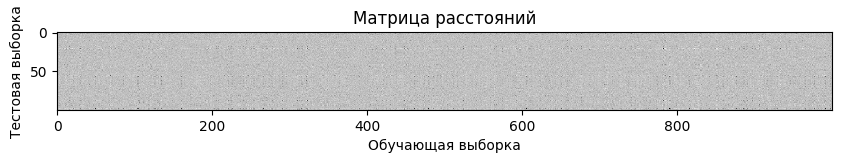

In [10]:
visualize_distance_matrix(classifier, x_test_flat, dists_one_loop)

(100, 1000)


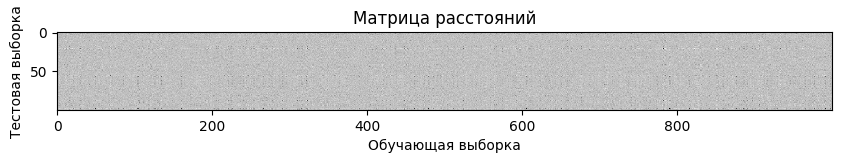

In [11]:
visualize_distance_matrix(classifier, x_test_flat, dists_no_loops)

(100, 1000)


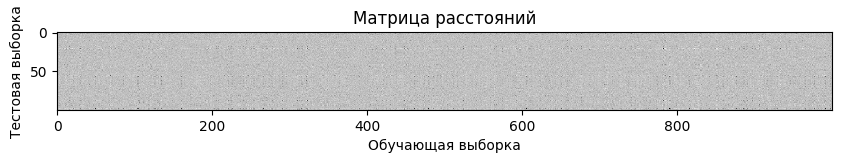

In [12]:
visualize_distance_matrix(classifier, x_test_flat, dists_two_loops)


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [13]:
from sklearn.metrics import accuracy_score

knn_y_test_predicts = classifier.predict_labels(dists_two_loops)

print(f'acc: {np.mean(knn_y_test_predicts == y_test)}')
print(f'acc: {accuracy_score(knn_y_test_predicts, y_test)}')

acc: 0.0961
acc: 0.19


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [14]:
predictions=[]
knn_accuracy=[]
neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]

for i in neighbors:
    pred = classifier.predict_labels(dists_two_loops, i)
    accuracy = accuracy_score(pred, y_test)
    print(f"{i}, accuracy= {accuracy}")
    predictions.append(pred)
    knn_accuracy.append(accuracy)

1, accuracy= 0.19
2, accuracy= 0.14
3, accuracy= 0.19
4, accuracy= 0.22
5, accuracy= 0.17
6, accuracy= 0.21
7, accuracy= 0.17
8, accuracy= 0.17
9, accuracy= 0.18
10, accuracy= 0.2
11, accuracy= 0.23
12, accuracy= 0.22
13, accuracy= 0.22
15, accuracy= 0.21
20, accuracy= 0.23
21, accuracy= 0.26
22, accuracy= 0.26
23, accuracy= 0.23
24, accuracy= 0.22
25, accuracy= 0.2
30, accuracy= 0.24
35, accuracy= 0.24
40, accuracy= 0.17
45, accuracy= 0.17
50, accuracy= 0.22


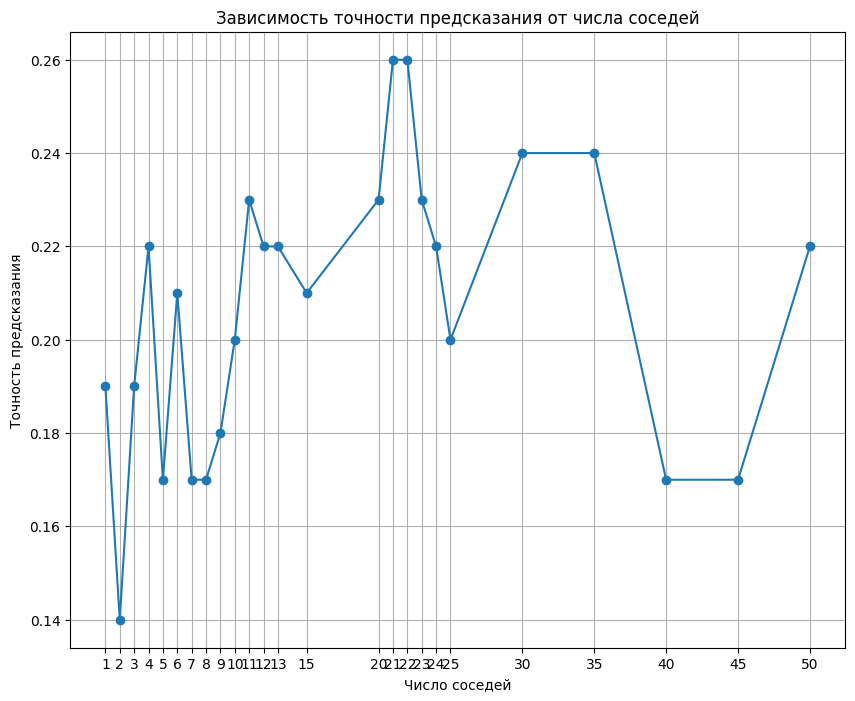

In [15]:
plt.plot(neighbors, knn_accuracy, marker='o')
plt.title('Зависимость точности предсказания от числа соседей')
plt.xlabel('Число соседей')
plt.ylabel('Точность предсказания')
plt.xticks(neighbors)
plt.grid(True)
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [16]:
best_k_index = np.argmax(knn_accuracy) # most accurate prediction
print(f"best k: {neighbors[best_k_index]}")
print(f"accuracy with the best k: {knn_accuracy[best_k_index]}")

best k: 21
accuracy with the best k: 0.26



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [17]:
def evaluate_accuracy(knn_model, dists, k, y_test_true):
    # Предсказываем метки классов для тестовых данных
    y_test_pred = knn_model.predict_labels(dists, k=k)
    # Оцениваем точность предсказания на тестовых данных
    accuracy = np.mean(y_test_pred == y_test_true)
    return accuracy


# Создаем экземпляр классификатора kNN с выбранным лучшим значением k
best_knn_model = KNearestNeighbor()
best_k = neighbors[best_k_index]  # Получаем выбранное лучшее значение k
best_knn_model.train(x_train_flat, y_train)  # Обучаем классификатор на обучающих данных

best_acc0 = evaluate_accuracy(best_knn_model, best_knn_model.compute_distances_no_loops(x_test_flat), best_k, knn_y_test_predicts)
best_acc1 = evaluate_accuracy(best_knn_model, best_knn_model.compute_distances_one_loop(x_test_flat), best_k, knn_y_test_predicts)
best_acc2 = evaluate_accuracy(best_knn_model, best_knn_model.compute_distances_two_loops(x_test_flat), best_k, knn_y_test_predicts)


In [18]:
print(best_acc0)
print(best_acc1)
print(best_acc2)

0.36
0.36
0.36


1.11 Сделайте выводы по результатам 1 части задания.

Когда рассматривается классификатор k-ближайших соседей, становится ясно, что его точность зависит от выбора количества соседей. Увеличение числа соседей приводит к увеличению времени обучения модели. Более того, при использовании большого количества соседей возрастает риск того, что модель может переобучиться, поэтому очень важно выбирать оптимальное значение параметра k.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [19]:
#from sklearn.model_selection import train_test_split
# Загрузка данных CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Разделение данных на обучающую, тестовую и валидационную выборки
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Размеры выборок
num_train = 49000
num_val = 1000
num_test = 8000

# Разделение выборок
svm_X_train, svm_X_val, svm_X_test = x_train[:num_train], x_train[num_train:num_train+num_val], x_test[:num_test]
svm_y_train, svm_y_val, svm_y_test = y_train[:num_train], y_train[num_train:num_train+num_val], y_test[:num_test]

# Преобразуем данные в нужный формат и тип
svm_X_train = np.reshape(svm_X_train, (svm_X_train.shape[0], -1)).astype(np.float64)
svm_X_val = np.reshape(svm_X_val, (svm_X_val.shape[0], -1)).astype(np.float64)
svm_X_test = np.reshape(svm_X_test, (svm_X_test.shape[0], -1)).astype(np.float64)

svm_y_train = np.reshape(svm_y_train, (svm_y_train.shape[0],))
svm_y_val = np.reshape(svm_y_val, (svm_y_val.shape[0],))
svm_y_test = np.reshape(svm_y_test, (svm_y_test.shape[0],))

# Выводим размеры данных
print("train:", svm_X_train.shape, svm_y_train.shape)
print("val:", svm_X_val.shape, svm_y_val.shape)
print("test:", svm_X_test.shape, svm_y_test.shape)

train: (49000, 3072) (49000,)
val: (1000, 3072) (1000,)
test: (8000, 3072) (8000,)


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

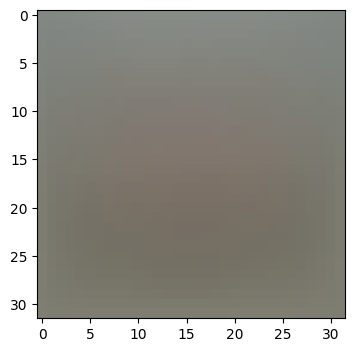

svm_X_train: (49000, 3073)
svm_X_val: (1000, 3073)
svm_X_test: (8000, 3073)


In [20]:
# Вычисляем среднее изображение по обучающей выборке
mean_image = np.mean(svm_X_train, axis=0)

# Визуализируем среднее изображение
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()
# Преобразуем среднее изображение к типу uint8
#mean_image = mean_image.astype('uint8')

# Проводим предварительную обработку данных: вычитаем среднее изображение из каждого изображения
svm_X_train -= mean_image
svm_X_val -= mean_image
svm_X_test -= mean_image

# Добавляем дополнительную размерность и заполняем ее единицами
svm_X_train = np.hstack([svm_X_train, np.ones((svm_X_train.shape[0], 1))])
svm_X_val = np.hstack([svm_X_val, np.ones((svm_X_val.shape[0], 1))])
svm_X_test = np.hstack([svm_X_test, np.ones((svm_X_test.shape[0], 1))])

# Выводим размеры выборок после предварительной обработки
print("svm_X_train:", svm_X_train.shape)
print("svm_X_val:", svm_X_val.shape)
print("svm_X_test:", svm_X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [31]:
def svm_loss_naive(W, X, y, reg):
    """
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """

    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    """

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W) # Вычисляем оценку для классов для 1го изображения
        correct_class_score = scores[y[i]] # Получаем оценку для правдивого класса
        for j in range(num_classes):
            if j == y[i]:
                continue
            # подсчитываем насколько ошиблись
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin # суммируем ошибки
                dW[:, j] += X[i] # т.к. это изображение добавило ошибку, то добавляем его в j класс
                dW[:, y[i]] -= X[i] # компенсируем то, что можем сделать это num_classes раз

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    dW /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)
    dW += reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

def svm_loss_vectorized(W, X, y, reg):

    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    scores = X.dot(W)

    # Делаем то же, что и в svm_loss_naive, только матрично
    correct_label_score_idxes = (range(scores.shape[0]), y)
    correct_label_scores = scores[correct_label_score_idxes]
    scores_diff = scores - np.reshape(correct_label_scores, (-1, 1)) + 1
    scores_diff[correct_label_score_idxes] = 0

    scores_diff[np.nonzero(scores_diff < 0)] = 0

    loss = scores_diff.sum()
    num_train = X.shape[0]
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    scores_diff[scores_diff > 0] = 1
    correct_label_vals = -1 * scores_diff.sum(axis=1)
    scores_diff[correct_label_score_idxes] = correct_label_vals

    dW = X.T.dot(scores_diff)
    dW /= num_train
    dW += reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

In [32]:
import time

W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, svm_X_val, svm_y_val, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.419738



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [33]:
from __future__ import print_function
from builtins import range
from past.builtins import xrange

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.

    We assume that f accepts several input blobs as arguments, followed by a
    blob where outputs will be written. For example, f might be called like:

    f(x, w, out)

    where x and w are input Blobs, and the result of f will be written to out.

    Inputs:
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [34]:
W = np.random.randn(3073, 10) * 0.0001
loss, grad = svm_loss_naive(W, svm_X_val, svm_y_val, 0.000005)
print('loss: %f' % (loss.item(), ))  # get scalar from tensor

loss: 8.674443


2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [35]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, svm_X_val, svm_y_val, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, svm_X_val, svm_y_val, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.389072s
Vectorized loss and gradient: computed in 0.023977s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [ ]:
from __future__ import annotations

from typing import TYPE_CHECKING

import numpy as np
from tqdm import tqdm

if TYPE_CHECKING:
    from typing import List


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(
            self,
            X: np.ndarray,
            y: np.ndarray,
            learning_rate: float = 1e-3,
            reg: float = 1e-5,
            num_iters: int = 100,
            batch_size: int = 200,
            verbose: bool = False,
    ) -> List[float]:
        """
        Train this linear classifier using stochastic gradient descent.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in tqdm(range(num_iters)):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            sample_index = np.random.choice(num_train, batch_size)
            X_batch = X[sample_index]
            y_batch = y[sample_index]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= grad * learning_rate

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        y_pred = np.argmax(X.dot(self.W), axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [ ]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(svm_X_train, svm_y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
y_train_pred = svm.predict(svm_X_train)
print('training accuracy: %f' % (np.mean(svm_y_train == y_train_pred), ))
y_val_pred = svm.predict(svm_X_val)
print('validation accuracy: %f' % (np.mean(svm_y_val == y_val_pred), ))

y_train_pred = svm.predict(svm_X_train)
print('training accuracy: %f' % (accuracy_score(svm_y_train, y_train_pred), ))
y_val_pred = svm.predict(svm_X_val)
print('validation accuracy: %f' % (accuracy_score(svm_y_val, y_val_pred), ))

2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
best_accuracy = 0
best_lr = 0
best_reg = 0
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]
np.random.seed(42)


for lr in learning_rates:
    for rs in regularization_strengths:
        # Создаем SVM модель и обучаем ее на обучающей выборке
        svm = LinearSVM()
        svm.train(svm_X_train, svm_y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=False)
        # Предсказываем метки классов для валидационной выборки
        y_val_pred = svm.predict(svm_X_val)

        # Обновляем лучшую точность и соответствующие значения скорости обучения и регуляризации,
        # если текущая точность лучше
        if ((np.mean(svm_y_val == y_val_pred)) > best_accuracy):
            best_lr = lr
            best_reg = rs
            best_accuracy = (np.mean(svm_y_val == y_val_pred))
        # Выводим текущую точность для данной комбинации параметров
        print(f'Lr: {lr}, reg: {rs}, accuracy: {(np.mean(svm_y_val == y_val_pred))}')

# Выводим лучший результат: точность, скорость обучения и силу регуляризации
print(f'Лучший результат: Точность: {best_accuracy}. Lr: {best_lr} , reg: {best_reg}')


In [ ]:
svm = LinearSVM()
svm.train(svm_X_train, svm_y_train, learning_rate=best_lr, reg=best_reg,
              num_iters=1500, verbose=False)
y_test_pred = svm.predict(svm_X_test)

y_test_pred = svm.predict(svm_X_test)
print(f'Точность на тестовой выборке: %f' % (np.mean(y_test == y_test_pred), ))

2.9 Сделайте выводы по второй части задания

Для SVM критически важен выбор оптимального значения параметра регуляризации, который может существенно повлиять на результаты обучения и обобщение модели. Кроме того, реализация svm_loss_naive работает дольше, чем реализация svm_loss_vectorized.